In [8]:
!mamba install pandas
!mamba install seaborn 
!mamba install requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
import time

import json
import os
import requests
from pathlib import Path
from io import StringIO

mambajs 0.19.13

Specs: xeus-python, numpy, matplotlib, pillow, ipywidgets>=8.1.6, ipyleaflet, scipy, pandas, seaborn
Channels: emscripten-forge, conda-forge

Solving environment...
Solving took 0.5273999999761582 seconds
All requested packages already installed.
mambajs 0.19.13

Specs: xeus-python, numpy, matplotlib, pillow, ipywidgets>=8.1.6, ipyleaflet, scipy, pandas, seaborn
Channels: emscripten-forge, conda-forge

Solving environment...
Solving took 0.3025 seconds
All requested packages already installed.
mambajs 0.19.13

Specs: xeus-python, numpy, matplotlib, pillow, ipywidgets>=8.1.6, ipyleaflet, scipy, pandas, seaborn, requests
Channels: emscripten-forge, conda-forge

Solving environment...
Solving took 0.2958999999761581 seconds
  Name                          Version                       Build                         Channel                       
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
+ brotli

In [9]:
def download_nyc_taxi_sample():
    """
    Загрузка небольшого образца данных о такси Нью-Йорка
    Используем данные за январь 2023 года (первые 10000 строк)
    """
    
    # URL для данных (январь 2023, желтое такси, первые 10000 строк)
    url = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet"
    
    print("Начинаем загрузку данных...")
    print("URL:", url)
    
    try:
        # Для parquet файлов используем read_parquet с явной установкой движка
        df = pd.read_parquet(url, engine='pyarrow')
        print(f"Загружено {len(df)} записей")
        
        # Берем только первые 10000 записей для быстроты
        if len(df) > 10000:
            df = df.head(10000)
            print(f"Используем первые 10000 записей")
        
        return df
        
    except Exception as e:
        print(f"Ошибка загрузки: {e}")
        print("Генерируем синтетические данные для демонстрации...")
        return generate_synthetic_taxi_data(5000)

def generate_synthetic_taxi_data(n_samples=5000):
    """
    Генерация синтетических данных о такси для демонстрации
    """
    np.random.seed(42)
    
    # Генерируем временной диапазон
    start_date = datetime(2023, 1, 1)
    end_date = datetime(2023, 1, 31)
    date_range = pd.date_range(start_date, end_date, periods=n_samples)
    
    # Создаем DataFrame с колонками как в реальных данных
    df = pd.DataFrame({
        'tpep_pickup_datetime': date_range,
        'tpep_dropoff_datetime': date_range + pd.to_timedelta(np.random.exponential(15, n_samples), unit='m'),
        'passenger_count': np.random.randint(1, 5, n_samples),
        'trip_distance': np.random.exponential(2.5, n_samples) + 0.5,
        'PULocationID': np.random.randint(1, 263, n_samples),
        'DOLocationID': np.random.randint(1, 263, n_samples),
        'fare_amount': np.random.exponential(12, n_samples) + 2.5,
        'tip_amount': np.random.exponential(2, n_samples),
        'total_amount': 0.0
    })
    
    # Добавляем логические зависимости
    df['tip_amount'] = df['tip_amount'] * (1 + 0.1 * df['passenger_count'])
    df['total_amount'] = df['fare_amount'] + df['tip_amount'] + 0.5
    
    return df

# Загружаем данные
print("Начинаем загрузку данных...")
df = download_nyc_taxi_sample()

# %% [markdown]
# ## 3. Первичный анализ данных

# %%
print("ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ")
print("="*60)

# Общая информация
print(f"\nРазмер данных: {df.shape[0]} строк, {df.shape[1]} столбцов")

# Типы данных
print(f"\nТипы данных:")
print(df.dtypes)

# Статистики
print(f"\nОсновные статистики:")
print(df.describe())

# Пропущенные значения
print(f"\nПропущенные значения:")
print(df.isnull().sum())

# Первые несколько строк
print(f"\nПервые 5 записей:")
print(df.head())

Начинаем загрузку данных...
Начинаем загрузку данных...
URL: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
Ошибка загрузки: `Import pyarrow` failed. pyarrow is required for parquet support. Use pip or conda to install the pyarrow package.
Генерируем синтетические данные для демонстрации...
ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ

Размер данных: 5000 строк, 9 столбцов

Типы данных:
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int32
trip_distance                   float64
PULocationID                      int32
DOLocationID                      int32
fare_amount                     float64
tip_amount                      float64
total_amount                    float64
dtype: object

Основные статистики:
             tpep_pickup_datetime          tpep_dropoff_datetime  \
count                        5000                           5000   
mean   2023-01-15 23:59:59.999999  2023-01-16 00:14:50.782322432  

In [11]:
print("ПОДГОТОВКА ДАННЫХ")
print("="*60)

# Создаем копию для обработки
df_clean = df.copy()

# 1. Проверяем наличие нужных колонок и создаем их при необходимости
if 'tpep_pickup_datetime' in df_clean.columns:
    # Извлечение признаков из даты
    df_clean['pickup_datetime'] = pd.to_datetime(df_clean['tpep_pickup_datetime'])
    df_clean['pickup_hour'] = df_clean['pickup_datetime'].dt.hour
    df_clean['pickup_day'] = df_clean['pickup_datetime'].dt.day
    df_clean['pickup_weekday'] = df_clean['pickup_datetime'].dt.dayofweek
    df_clean['pickup_month'] = df_clean['pickup_datetime'].dt.month
else:
    # Создаем временные признаки на основе индекса
    df_clean['pickup_hour'] = np.random.randint(0, 24, len(df_clean))
    df_clean['pickup_weekday'] = np.random.randint(0, 7, len(df_clean))
    df_clean['pickup_day'] = np.random.randint(1, 31, len(df_clean))

# 2. Фильтрация аномалий (если есть нужные колонки)
if 'passenger_count' in df_clean.columns:
    df_clean = df_clean[df_clean['passenger_count'] > 0]
    df_clean = df_clean[df_clean['passenger_count'] <= 6]

if 'fare_amount' in df_clean.columns:
    df_clean = df_clean[df_clean['fare_amount'] >= 2.5]
    df_clean = df_clean[df_clean['fare_amount'] <= 150]

if 'tip_amount' in df_clean.columns:
    df_clean = df_clean[df_clean['tip_amount'] >= 0]
    df_clean = df_clean[df_clean['tip_amount'] <= 50]

if 'trip_distance' in df_clean.columns:
    df_clean = df_clean[df_clean['trip_distance'] > 0]
    df_clean = df_clean[df_clean['trip_distance'] <= 50]

# 3. Добавление новых признаков
if 'fare_amount' in df_clean.columns and 'tip_amount' in df_clean.columns:
    df_clean['tip_percentage'] = (df_clean['tip_amount'] / df_clean['fare_amount']) * 100
    df_clean['tip_percentage'] = df_clean['tip_percentage'].clip(0, 100)

if 'fare_amount' in df_clean.columns and 'trip_distance' in df_clean.columns:
    df_clean['price_per_km'] = df_clean['fare_amount'] / df_clean['trip_distance']
    df_clean['price_per_km'] = df_clean['price_per_km'].clip(0, 50)

if 'pickup_weekday' in df_clean.columns:
    df_clean['is_weekend'] = df_clean['pickup_weekday'].apply(lambda x: 1 if x >= 5 else 0)

if 'pickup_hour' in df_clean.columns:
    df_clean['is_rush_hour'] = df_clean['pickup_hour'].apply(
        lambda x: 1 if (7 <= x <= 9) or (17 <= x <= 19) else 0
    )
print(f"После очистки: {len(df_clean)} записей")
print(f"Добавлены признаки: pickup_hour, pickup_weekday, tip_percentage, price_per_km, is_weekend, is_rush_hour")


ПОДГОТОВКА ДАННЫХ
После очистки: 5000 записей
Добавлены признаки: pickup_hour, pickup_weekday, tip_percentage, price_per_km, is_weekend, is_rush_hour



Статистика по часам (первые 5):
   pickup_hour  count_fare_amount  avg_fare_amount  std_fare_amount  \
0            0              13.73            10.21             2.55   
1            1              15.45            12.65             2.35   
2            2              12.96             9.92             2.62   
3            3              14.79            12.32             2.47   
4            4              15.52            13.51             2.28   

   count_tip_amount  avg_tip_amount  
0              2.88             210  
1              3.12             208  
2              2.90             208  
3              2.80             209  
4              3.22             208  

Статистика по дням недели:
    avg_fare  avg_tip  avg_tip_pct  avg_distance  trip_count
Пн     14.41     2.31        25.46          2.94         833
Вт     14.01     2.53        27.47          2.94         667
Ср     13.95     2.52        27.56          3.04         666
Чт     14.28     2.53        26.17      

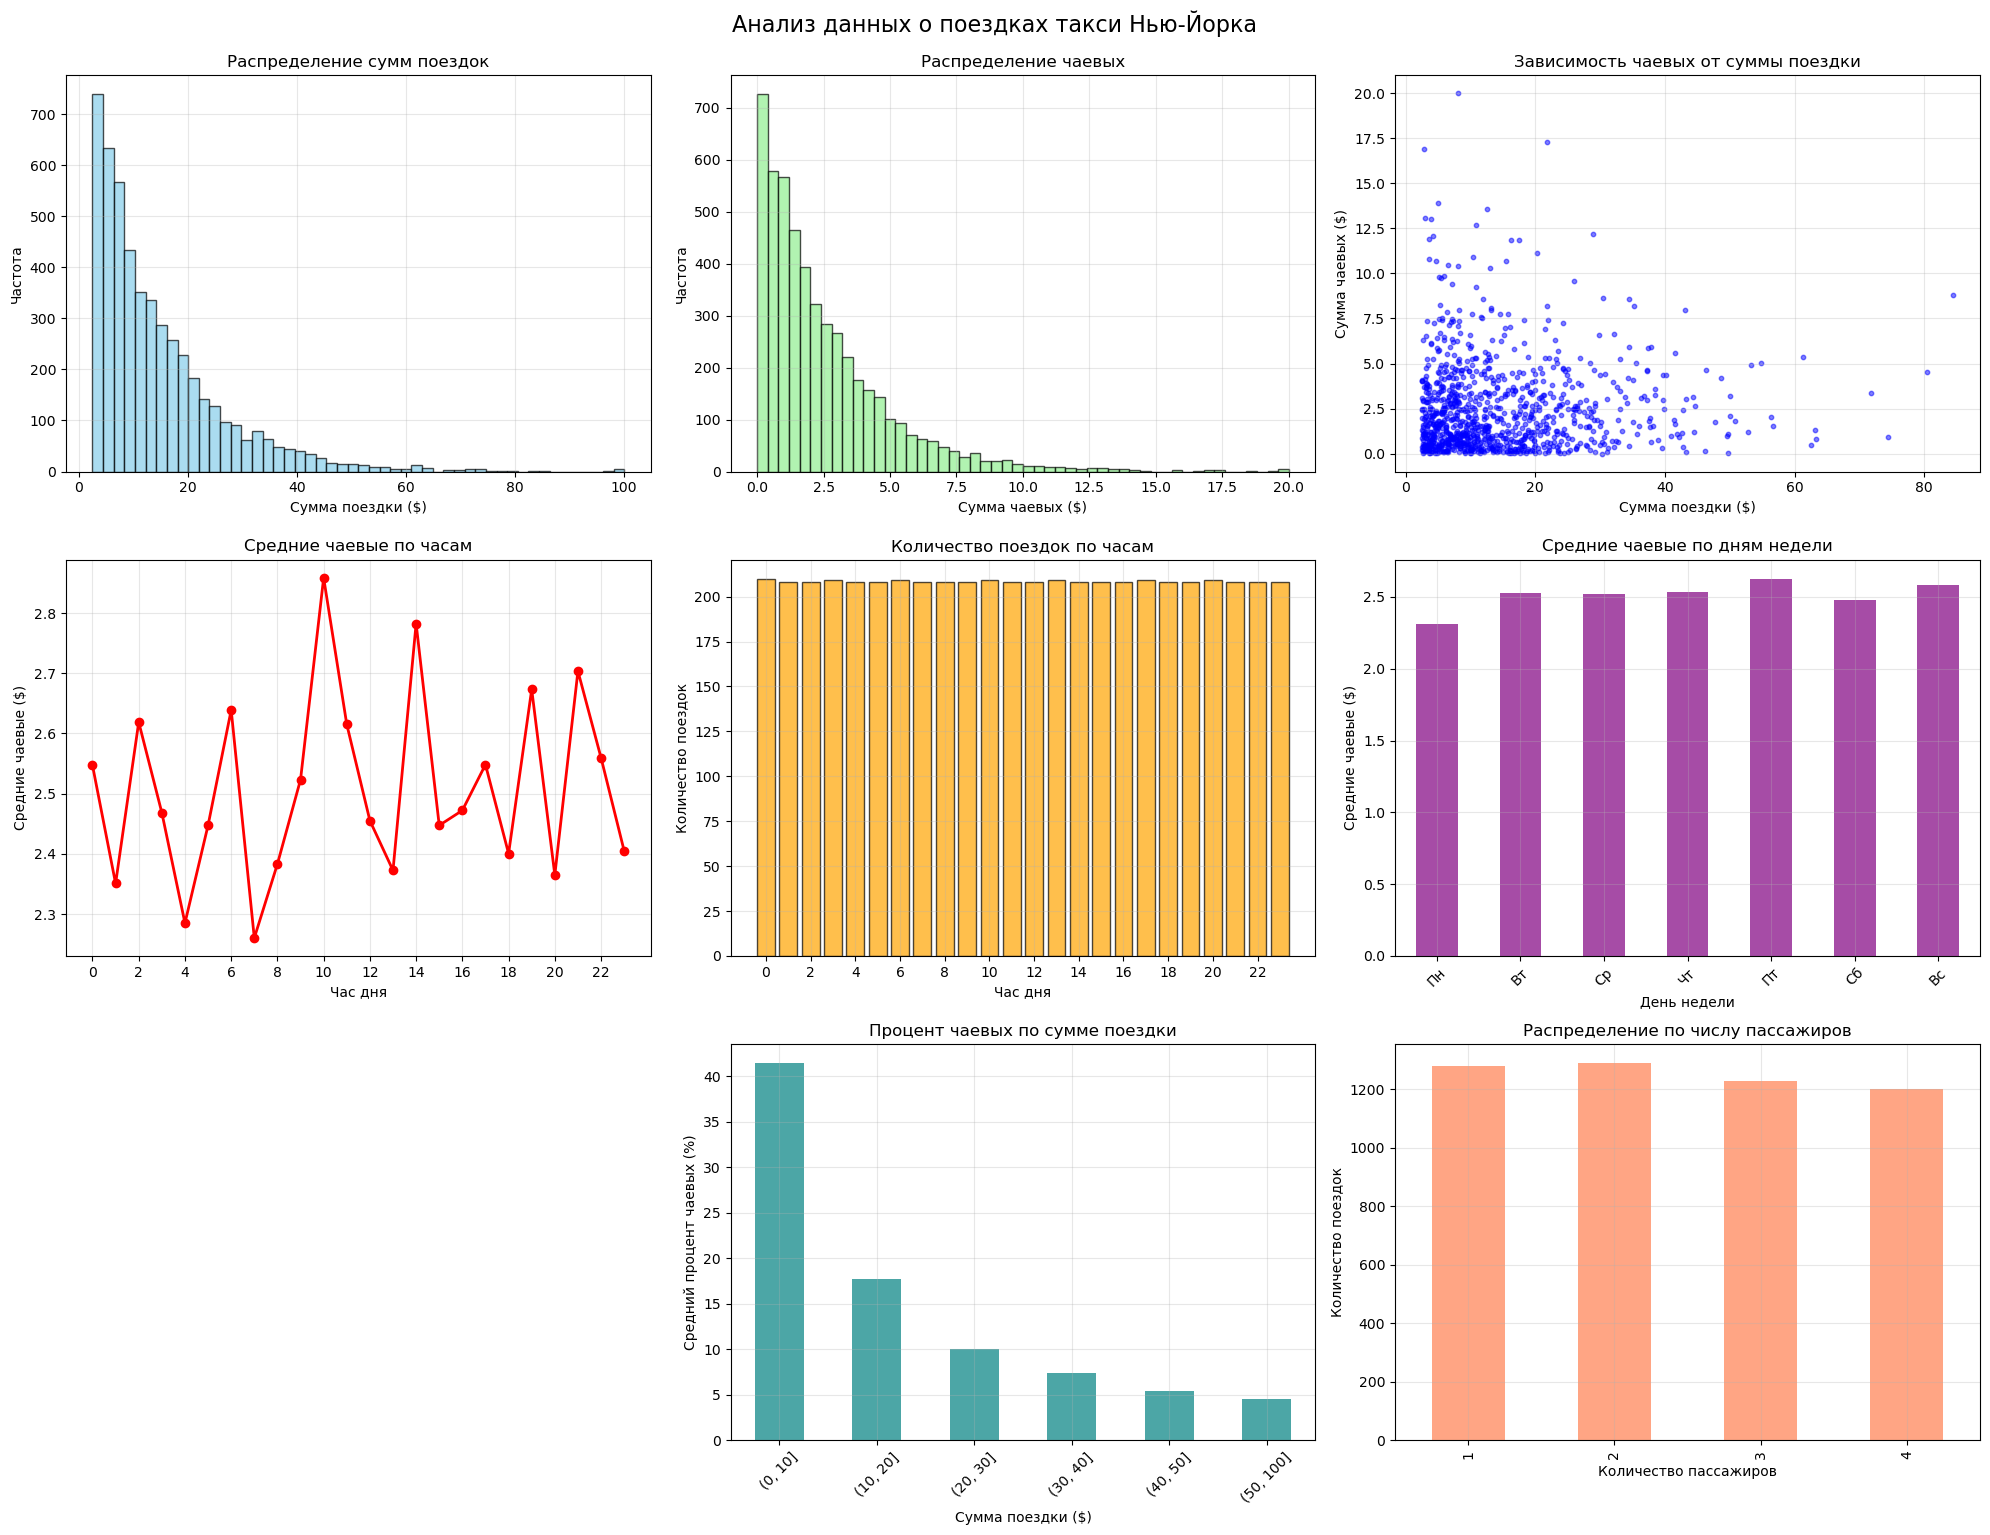

In [12]:
if 'pickup_hour' in df_clean.columns:
    hourly_stats = df_clean.groupby('pickup_hour').agg({
        'fare_amount': ['mean', 'std'] if 'fare_amount' in df_clean.columns else 'count',
        'tip_amount': 'mean' if 'tip_amount' in df_clean.columns else 'count',
        'trip_distance': 'mean' if 'trip_distance' in df_clean.columns else 'count',
        'passenger_count': 'count' if 'passenger_count' in df_clean.columns else 'count'
    }).round(2)
    
    new_columns = []
    for col in hourly_stats.columns.levels[0]:
        for stat in hourly_stats.columns.levels[1]:
            if stat == 'mean':
                new_columns.append(f'avg_{col}')
            elif stat == 'std':
                new_columns.append(f'std_{col}')
            elif stat == 'count':
                new_columns.append(f'count_{col}')
    
    hourly_stats.columns = new_columns[:len(hourly_stats.columns)]
    hourly_stats = hourly_stats.reset_index()
    
    print("\nСтатистика по часам (первые 5):")
    print(hourly_stats.head())

# Анализ по дням недели
if 'pickup_weekday' in df_clean.columns:
    weekday_stats = df_clean.groupby('pickup_weekday').agg({
        'fare_amount': 'mean' if 'fare_amount' in df_clean.columns else 'count',
        'tip_amount': 'mean' if 'tip_amount' in df_clean.columns else 'count',
        'tip_percentage': 'mean' if 'tip_percentage' in df_clean.columns else 'count',
        'trip_distance': 'mean' if 'trip_distance' in df_clean.columns else 'count',
        'passenger_count': 'count' if 'passenger_count' in df_clean.columns else 'count'
    }).round(2)
    
    weekday_stats.columns = ['avg_fare', 'avg_tip', 'avg_tip_pct', 'avg_distance', 'trip_count'][:len(weekday_stats.columns)]
    weekday_stats.index = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'][:len(weekday_stats)]
    
    print("\nСтатистика по дням недели:")
    print(weekday_stats)

# Анализ зависимости чаевых от суммы поездки
if 'fare_amount' in df_clean.columns and 'tip_amount' in df_clean.columns:
    print("\nКорреляция между суммой поездки и чаевыми:")
    correlation = df_clean['fare_amount'].corr(df_clean['tip_amount'])
    print(f"  Коэффициент корреляции: {correlation:.3f}")


# Создаем фигуру с подграфиками
fig = plt.figure(figsize=(20, 15))

plot_idx = 1

# Распределение сумм поездок
if 'fare_amount' in df_clean.columns:
    ax1 = plt.subplot(3, 3, 1)
    ax1.hist(df_clean['fare_amount'].clip(0, 100), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Сумма поездки ($)')
    ax1.set_ylabel('Частота')
    ax1.set_title('Распределение сумм поездок')
    ax1.grid(True, alpha=0.3)

# Распределение чаевых
if 'tip_amount' in df_clean.columns:
    ax2 = plt.subplot(3, 3, 2)
    ax2.hist(df_clean['tip_amount'].clip(0, 20), bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Сумма чаевых ($)')
    ax2.set_ylabel('Частота')
    ax2.set_title('Распределение чаевых')
    ax2.grid(True, alpha=0.3)

# Зависимость чаевых от суммы поездки
if 'fare_amount' in df_clean.columns and 'tip_amount' in df_clean.columns:
    ax3 = plt.subplot(3, 3, 3)
    sample_df = df_clean.sample(min(1000, len(df_clean)))
    ax3.scatter(sample_df['fare_amount'].clip(0, 100), sample_df['tip_amount'].clip(0, 20), 
                alpha=0.5, c='blue', s=10)
    ax3.set_xlabel('Сумма поездки ($)')
    ax3.set_ylabel('Сумма чаевых ($)')
    ax3.set_title('Зависимость чаевых от суммы поездки')
    ax3.grid(True, alpha=0.3)

# Средние чаевые по часам
if 'pickup_hour' in df_clean.columns and 'tip_amount' in df_clean.columns:
    ax4 = plt.subplot(3, 3, 4)
    hourly_tips = df_clean.groupby('pickup_hour')['tip_amount'].mean()
    ax4.plot(hourly_tips.index, hourly_tips.values, 
             marker='o', color='red', linewidth=2)
    ax4.set_xlabel('Час дня')
    ax4.set_ylabel('Средние чаевые ($)')
    ax4.set_title('Средние чаевые по часам')
    ax4.grid(True, alpha=0.3)
    ax4.set_xticks(range(0, 24, 2))

# Количество поездок по часам
if 'pickup_hour' in df_clean.columns:
    ax5 = plt.subplot(3, 3, 5)
    hourly_counts = df_clean.groupby('pickup_hour').size()
    ax5.bar(hourly_counts.index, hourly_counts.values, 
            color='orange', alpha=0.7, edgecolor='black')
    ax5.set_xlabel('Час дня')
    ax5.set_ylabel('Количество поездок')
    ax5.set_title('Количество поездок по часам')
    ax5.grid(True, alpha=0.3)
    ax5.set_xticks(range(0, 24, 2))

# Средние чаевые по дням недели
if 'pickup_weekday' in df_clean.columns and 'tip_amount' in df_clean.columns:
    ax6 = plt.subplot(3, 3, 6)
    weekday_tips = df_clean.groupby('pickup_weekday')['tip_amount'].mean()
    weekday_tips.index = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
    weekday_tips.plot(kind='bar', ax=ax6, color='purple', alpha=0.7)
    ax6.set_xlabel('День недели')
    ax6.set_ylabel('Средние чаевые ($)')
    ax6.set_title('Средние чаевые по дням недели')
    ax6.grid(True, alpha=0.3)
    ax6.tick_params(axis='x', rotation=45)

# Процент чаевых по сумме поездки
if 'fare_amount' in df_clean.columns and 'tip_percentage' in df_clean.columns:
    ax8 = plt.subplot(3, 3, 8)
    bins = [0, 10, 20, 30, 40, 50, 100]
    df_clean['fare_bin'] = pd.cut(df_clean['fare_amount'].clip(0, 100), bins)
    tip_by_fare = df_clean.groupby('fare_bin')['tip_percentage'].mean()
    tip_by_fare.plot(kind='bar', ax=ax8, color='teal', alpha=0.7)
    ax8.set_xlabel('Сумма поездки ($)')
    ax8.set_ylabel('Средний процент чаевых (%)')
    ax8.set_title('Процент чаевых по сумме поездки')
    ax8.tick_params(axis='x', rotation=45)
    ax8.grid(True, alpha=0.3)

# Распределение количества пассажиров
if 'passenger_count' in df_clean.columns:
    ax9 = plt.subplot(3, 3, 9)
    df_clean['passenger_count'].value_counts().sort_index().plot(
        kind='bar', ax=ax9, color='coral', alpha=0.7)
    ax9.set_xlabel('Количество пассажиров')
    ax9.set_ylabel('Количество поездок')
    ax9.set_title('Распределение по числу пассажиров')
    ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Анализ данных о поездках такси Нью-Йорка', y=1.02, fontsize=16)
plt.show()